# **Rice Grain image classification**

In [1]:
# Standard Python Libraries
import os
import cv2
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning and Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50, DenseNet121

# Machine Learning Metrics
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Image Quality Metrics
from skimage.metrics import structural_similarity as compare_ssim

print("Success in importing libs")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Success in importing libs


### **Data Preparation**

In [2]:
num_classes = 5

# Define your dataset directory where you've stored the rice grain images.
data_dir = '/kaggle/input/rice-data/Rice_Image_Dataset'

# List of rice variety folders in your dataset.
rice_varieties = os.listdir(data_dir)

# Initialize lists to store images and corresponding labels.
images = []
labels = []

# Load images and labels.
for variety in rice_varieties:
    variety_path = os.path.join(data_dir, variety)
    image_list = os.listdir(variety_path)
    for image_name in image_list:
        image_path = os.path.join(variety_path, image_name)
        images.append(image_path)
        labels.append(variety)

# Convert labels to numerical values.
label_to_index = {variety: index for index, variety in enumerate(rice_varieties)}
labels = [label_to_index[label] for label in labels]

# Split the data into training, validation, and test sets.
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Step Success")

Step Success


### **Data Preprocessing**

In [3]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(75, 75)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    return img, img_array  # Return the original image and the preprocessed image

# Load and preprocess images for training set
X_train_processed = np.array([load_and_preprocess_image(image_path)[1] for image_path in X_train])
y_train_categorical = np.array(y_train)

# Load and preprocess images for validation set
X_val_processed = np.array([load_and_preprocess_image(image_path)[1] for image_path in X_val])
y_val_categorical = np.array(y_val)

# Load and preprocess images for test set
X_test_processed = np.array([load_and_preprocess_image(image_path)[1] for image_path in X_test])
y_test_categorical = np.array(y_test)

print("Step Success")

Step Success


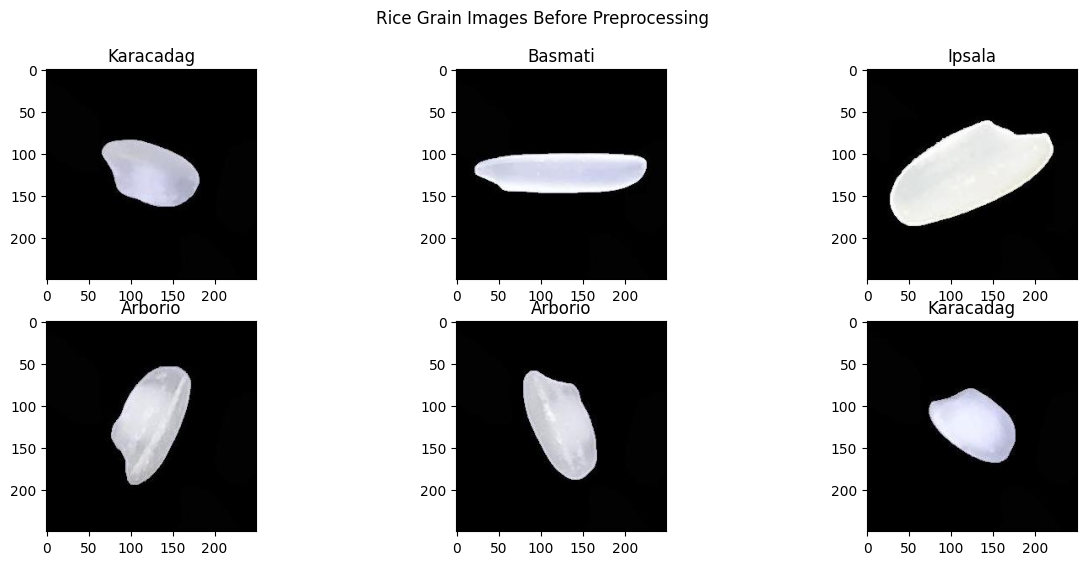

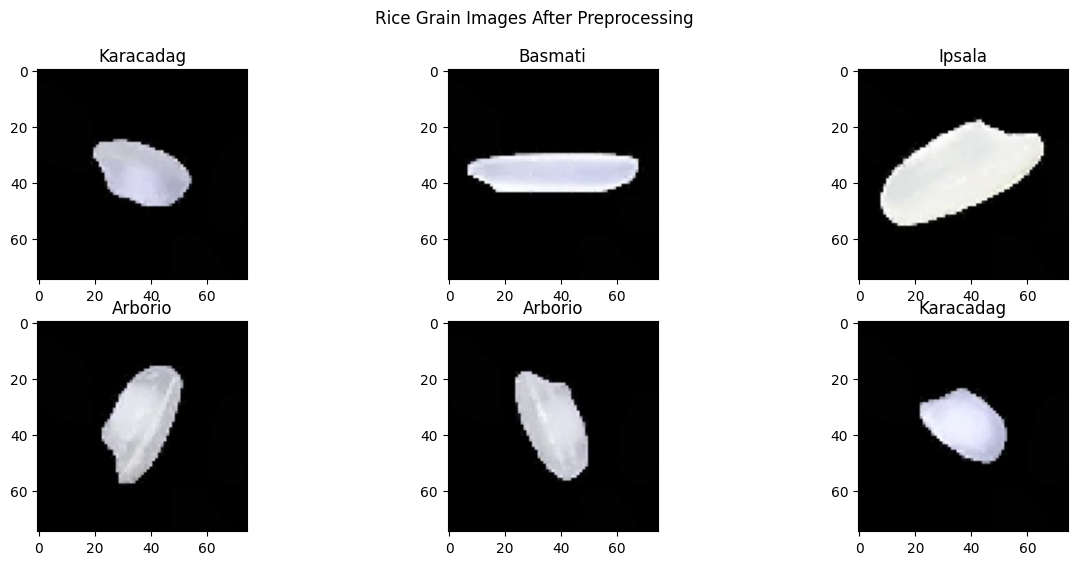

In [4]:
# Displaying some rice grain images before preprocessing
plt.figure(figsize=(15, 6))
for i in range(6):  # Display the first 6 images
    plt.subplot(2, 3, i + 1)
    img = plt.imread(X_train[i])
    plt.imshow(img)
    plt.title(rice_varieties[y_train[i]])
plt.suptitle('Rice Grain Images Before Preprocessing')
plt.show()

# Displaying some rice grain images after preprocessing
plt.figure(figsize=(15, 6))
for i in range(6):  # Display the first 6 images
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_train_processed[i])
    plt.title(rice_varieties[y_train[i]])
plt.suptitle('Rice Grain Images After Preprocessing')
plt.show()

### **Modeling**

In [5]:
from tensorflow.keras.utils import to_categorical

y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_val_categorical = to_categorical(y_val, num_classes=num_classes)

In [6]:
from sklearn.metrics import accuracy_score, log_loss

models = ["VGG-16", "ResNet", "DenseNet", "Inception", "Xception", "MobileNet", "VGG19"]

train_acc = []
test_acc = []
val_acc = []
train_loss = []
test_loss = []
val_loss = []

**VGG-16 Model**

In [7]:
# Step 3: Model Architecture

# Load the pre-trained VGG-16 model (without top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # You can adjust the dropout rate
predictions = Dense(num_classes, activation='softmax')(x)  # 'num_classes' is the number of classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# You can print the model summary to see the architecture
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                              

In [8]:
# Step 4: Training the Model

# Define the number of epochs and batch size
epochs = 10
batch_size = 32

# Set up callbacks
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

# Train the model
history = model.fit(
    X_train_processed, y_train_categorical,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_processed, y_val_categorical),
    callbacks=[model_checkpoint, early_stopping]
)

# Save the model
model.save('final_model.h5')

Epoch 1/10
547/547 [==============================] - ETA: 0s - loss: 0.4927 - accuracy: 0.7835
Epoch 1: val_accuracy improved from inf to 0.95227, saving model to best_model.h5
547/547 [==============================] - 61s 73ms/step - loss: 0.4927 - accuracy: 0.7835 - val_loss: 0.1588 - val_accuracy: 0.9523
Epoch 2/10
547/547 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9500
Epoch 2: val_accuracy improved from 0.95227 to 0.91787, saving model to best_model.h5
547/547 [==============================] - 38s 70ms/step - loss: 0.1581 - accuracy: 0.9500 - val_loss: 0.2367 - val_accuracy: 0.9179
Epoch 3/10
547/547 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9586
Epoch 3: val_accuracy did not improve from 0.91787
547/547 [==============================] - 38s 70ms/step - loss: 0.1272 - accuracy: 0.9586 - val_loss: 0.0440 - val_accuracy: 0.9875
Epoch 4/10
547/547 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.969

In [9]:
from tensorflow.keras.utils import to_categorical

y_test_categorical = to_categorical(y_test, num_classes=num_classes)

In [10]:
# Evaluate the model on the test set
model.load_weights('best_model.h5')  # Load the weights of the best model during training
y_pred = model.predict(X_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Display classification report
print(classification_report(y_true, y_pred_classes))

118/118 [==============================] - 2s 20ms/step
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       742
           1       1.00      0.94      0.97       732
           2       0.95      0.94      0.95       752
           3       0.92      0.77      0.84       757
           4       0.91      1.00      0.95       767

    accuracy                           0.92      3750
   macro avg       0.92      0.92      0.92      3750
weighted avg       0.92      0.92      0.92      3750



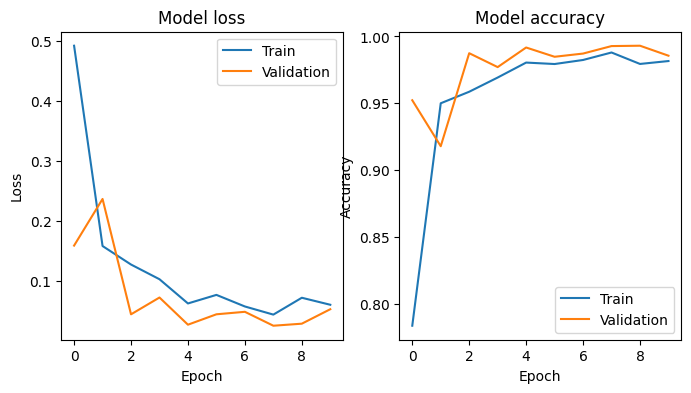

In [11]:
# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

In [12]:
# Step 4: Evaluation

# Load the saved model
model.load_weights('best_model.h5')  # Load the best weights obtained during training

# Make predictions on the test set
predictions = model.predict(X_test_processed)

# Evaluate the model on the test set
vgg_test_loss, vgg_test_accuracy = model.evaluate(X_test_processed, y_test_categorical, verbose=1)

# Print the test accuracy
print("Test Accuracy: {:.2f}%".format(vgg_test_accuracy * 100))

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class labels
true_classes = np.argmax(y_test_categorical, axis=1)

# Calculate evaluation metrics

# Generate classification report
class_labels = list(label_to_index.keys())
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

train_acc.append(history.history['accuracy'][-1])
val_acc.append(history.history['val_accuracy'][-1])
test_acc.append(accuracy_score(true_classes, predicted_classes))

train_loss.append(history.history['loss'][-1])
val_loss.append(history.history['val_loss'][-1])
test_loss.append(log_loss(y_test_categorical, predictions))

118/118 [==============================] - 2s 20ms/step - loss: 0.2285 - accuracy: 0.9184
Test Accuracy: 91.84%
Classification Report:
              precision    recall  f1-score   support

   Karacadag       0.83      0.94      0.88       742
     Basmati       1.00      0.94      0.97       732
     Jasmine       0.95      0.94      0.95       752
     Arborio       0.92      0.77      0.84       757
      Ipsala       0.91      1.00      0.95       767

    accuracy                           0.92      3750
   macro avg       0.92      0.92      0.92      3750
weighted avg       0.92      0.92      0.92      3750

Confusion Matrix:
[[695   0   0  47   0]
 [  4 688  34   6   0]
 [ 42   0 710   0   0]
 [ 97   0   1 584  75]
 [  0   0   0   0 767]]


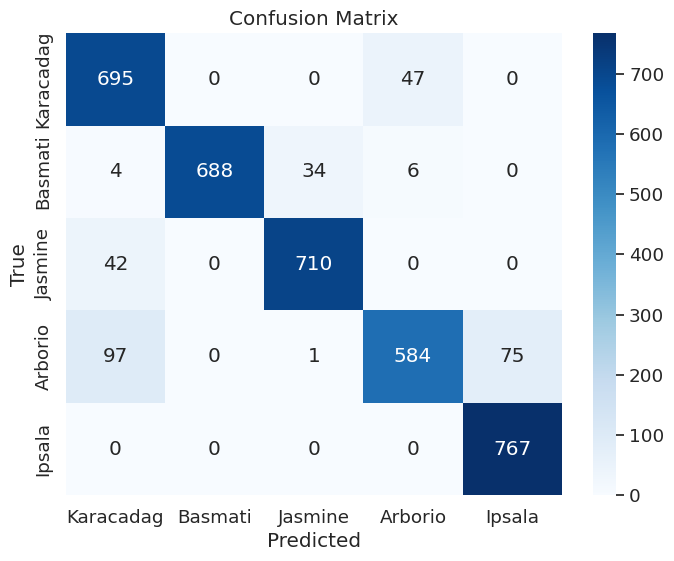

In [13]:
# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale as needed

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
# Set axis labels and plot title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
# Display the plot
plt.show()

In [14]:
# Define a function to create and compile a model
def create_model(base_model, input_shape):
    base = base_model(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)  # Updated to have 'num_classes' units
    model = Model(inputs=base.input, outputs=predictions)
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

**Resnet Architecture**

In [15]:
epochs = 20
batch_size = 32

# Set up callbacks to save only the weights
model_checkpoint = ModelCheckpoint('resnet_model_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Model 2: ResNet
model_resnet = create_model(ResNet50, (75, 75, 3))

# Train the ResNet model
history_1 = model_resnet.fit(X_train_processed, y_train_categorical, epochs=epochs, batch_size=batch_size, validation_data=(X_val_processed, y_val_categorical), callbacks=[model_checkpoint, early_stopping])
print("Done 3rd")

94765736/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 81, 81, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 38, 38, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 38, 38, 64)   256         ['conv1_conv[0][0]']             
                           

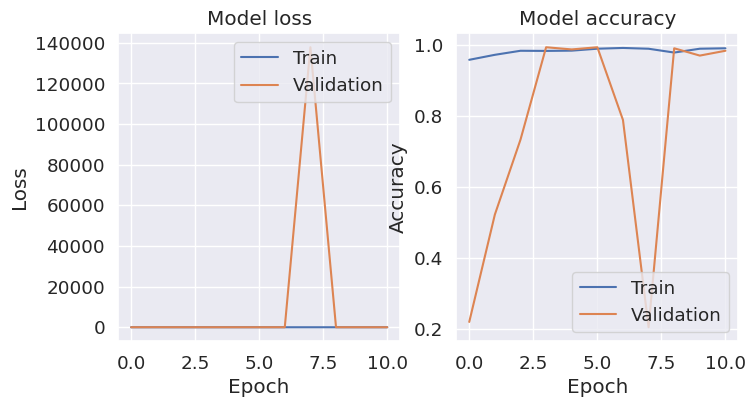

In [16]:
# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(122)
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

118/118 [==============================] - 2s 20ms/step - loss: 0.0264 - accuracy: 0.9917
Test Accuracy: 99.17%
Classification Report:
              precision    recall  f1-score   support

   Karacadag       1.00      0.98      0.99       742
     Basmati       1.00      0.99      0.99       732
     Jasmine       0.99      0.99      0.99       752
     Arborio       0.98      1.00      0.99       757
      Ipsala       1.00      1.00      1.00       767

    accuracy                           0.99      3750
   macro avg       0.99      0.99      0.99      3750
weighted avg       0.99      0.99      0.99      3750

Confusion Matrix:
[[727   0   0  15   0]
 [  0 723   9   0   0]
 [  0   3 747   2   0]
 [  2   0   0 755   0]
 [  0   0   0   0 767]]


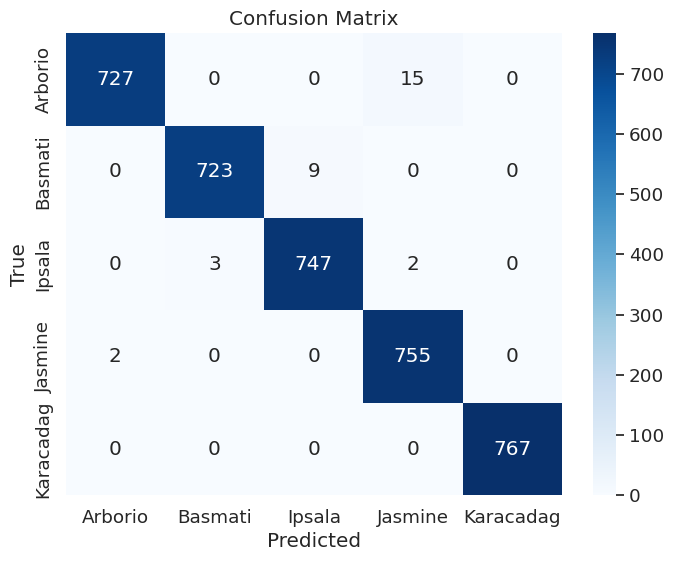

In [17]:
# Step 4: Evaluation

# Assuming you have 'num_classes' defined as the number of classes
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Load the saved model
model_resnet.load_weights('resnet_model_weights.h5')  # Load the best weights obtained during training

# Make predictions on the test set
predictions = model_resnet.predict(X_test_processed)

# Evaluate the model on the test set
resnet_test_loss, resnet_test_accuracy = model_resnet.evaluate(X_test_processed, y_test_categorical, verbose=1)

# Print the test accuracy
print("Test Accuracy: {:.2f}%".format(resnet_test_accuracy * 100))

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class labels
true_classes = np.argmax(y_test_categorical, axis=1)

# Generate classification report
class_labels = list(label_to_index.keys())
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

class_labels = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale as needed

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
# Set axis labels and plot title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

train_acc.append(history_1.history['accuracy'][-1])
val_acc.append(history_1.history['val_accuracy'][-1])
test_acc.append(accuracy_score(true_classes, predicted_classes))

train_loss.append(history_1.history['loss'][-1])
val_loss.append(history_1.history['val_loss'][-1])
test_loss.append(log_loss(y_test_categorical, predictions))


**DenseNet Architecture**

In [18]:
# Set up callbacks to save only the weights
model_checkpoint = ModelCheckpoint('densenet_model_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Model 3: DenseNet
model_densenet = create_model(DenseNet121, (75, 75, 3))

# Train the Densenet model
history_2 = model_densenet.fit(X_train_processed, y_train_categorical, epochs=epochs, batch_size=batch_size, validation_data=(X_val_processed, y_val_categorical), callbacks=[model_checkpoint, early_stopping])
print("Done 3rd")

29084464/29084464 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 81, 81, 3)   0           ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 38, 38, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 38, 38, 64)   256         ['conv1/conv[0][0]']             
                           

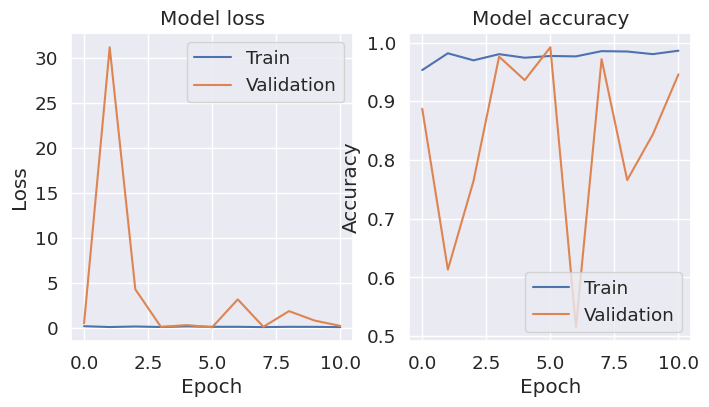

In [19]:
# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(122)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

118/118 [==============================] - 2s 18ms/step - loss: 0.0316 - accuracy: 0.9923
Test Accuracy: 99.23%
Classification Report:
              precision    recall  f1-score   support

   Karacadag       1.00      0.99      1.00       742
     Basmati       0.99      1.00      1.00       732
     Jasmine       0.98      0.99      0.99       752
     Arborio       0.99      0.98      0.99       757
      Ipsala       1.00      1.00      1.00       767

    accuracy                           0.99      3750
   macro avg       0.99      0.99      0.99      3750
weighted avg       0.99      0.99      0.99      3750

Confusion Matrix:
[[738   0   0   4   0]
 [  0 732   0   0   0]
 [  0   7 745   0   0]
 [  3   0  15 739   0]
 [  0   0   0   0 767]]


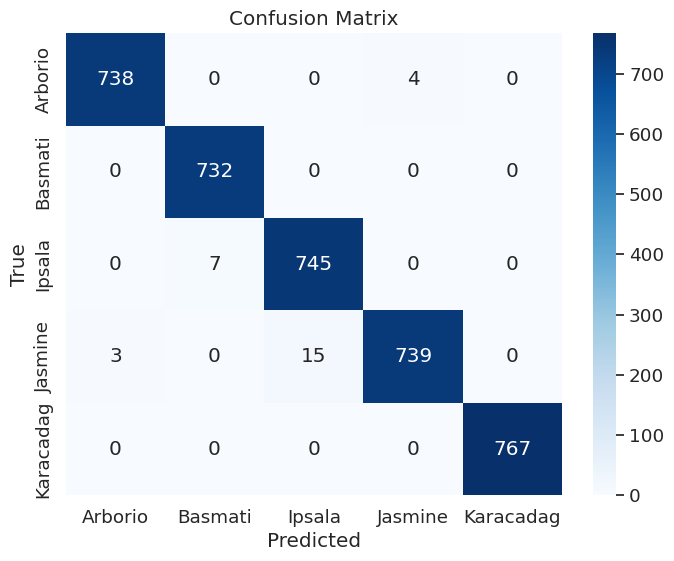

In [20]:
# Step 4: Evaluation

# Assuming you have 'num_classes' defined as the number of classes
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Load the saved model
model_densenet.load_weights('densenet_model_weights.h5')  # Load the best weights obtained during training

# Make predictions on the test set
predictions = model_densenet.predict(X_test_processed)

# Evaluate the model on the test set
desnenet_test_loss, desnenet_test_accuracy = model_densenet.evaluate(X_test_processed, y_test_categorical, verbose=1)

# Print the test accuracy
print("Test Accuracy: {:.2f}%".format(desnenet_test_accuracy * 100))

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class labels
true_classes = np.argmax(y_test_categorical, axis=1)

# Generate classification report
class_labels = list(label_to_index.keys())
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

class_labels = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale as needed

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
# Set axis labels and plot title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

train_acc.append(history_2.history['accuracy'][-1])
val_acc.append(history_2.history['val_accuracy'][-1])
test_acc.append(accuracy_score(true_classes, predicted_classes))

train_loss.append(history_2.history['loss'][-1])
val_loss.append(history_2.history['val_loss'][-1])
test_loss.append(log_loss(y_test_categorical, predictions))


**Inception Model**

In [21]:
from tensorflow.keras.applications import InceptionV3

# Load the pre-trained InceptionV3 model (without top classification layers)
input_shape = (75, 75, 3)  # Adjust as needed
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model_inception = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_inception.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define the number of epochs and batch size
epochs = 20
batch_size = 32

# Set up callbacks
model_checkpoint = ModelCheckpoint('inception_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train the model
history_3 = model_inception.fit(
    X_train_processed, y_train_categorical,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_processed, y_val_categorical),
    callbacks=[model_checkpoint, early_stopping]
)

# Save the model
model_inception.save('final_inception_model.h5')

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/20
547/547 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.9391
Epoch 1: val_loss improved from inf to 0.73742, saving model to inception_model.h5
547/547 [==============================] - 76s 62ms/step - loss: 0.2590 - accuracy: 0.9391 - val_loss: 0.7374 - val_accuracy: 0.7651
Epoch 2/20
546/547 [============================>.] - ETA: 0s - loss: 0.0663 - accuracy: 0.9829
Epoch 2: val_loss improved from 0.73742 to 0.03976, saving model to inception_model.h5
547/547 [==============================] - 29s 54ms/step - loss: 0.0662 - accuracy: 0.9830 - val_loss: 0.0398 - val_accuracy: 0.9896
Epoch 3/20
546/547 [============================>.] - ETA: 0s - loss: 0.0836 - accuracy: 0.9862
Epoch 3: val_loss did not improve from 0.03976
547/547 [==============================] - 29s 52ms/step - loss: 0.0837 - accuracy: 0.9861 - val_loss: 0.1860 - val_accuracy: 0.9400
Epoch 4/20
546/547 [===========

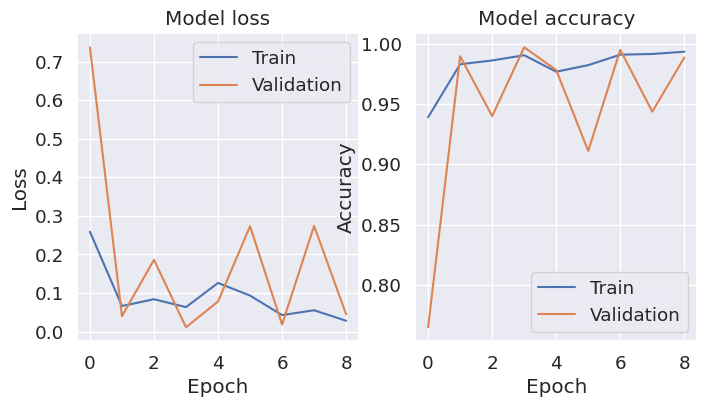

In [22]:
# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(122)
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

118/118 [==============================] - 2s 14ms/step - loss: 0.0081 - accuracy: 0.9973
Test Accuracy: 99.73%
Classification Report:
              precision    recall  f1-score   support

   Karacadag       1.00      0.99      1.00       742
     Basmati       0.99      1.00      1.00       732
     Jasmine       1.00      1.00      1.00       752
     Arborio       0.99      1.00      1.00       757
      Ipsala       1.00      1.00      1.00       767

    accuracy                           1.00      3750
   macro avg       1.00      1.00      1.00      3750
weighted avg       1.00      1.00      1.00      3750

Confusion Matrix:
[[737   1   0   4   0]
 [  0 732   0   0   0]
 [  0   3 749   0   0]
 [  0   0   1 756   0]
 [  0   0   0   1 766]]


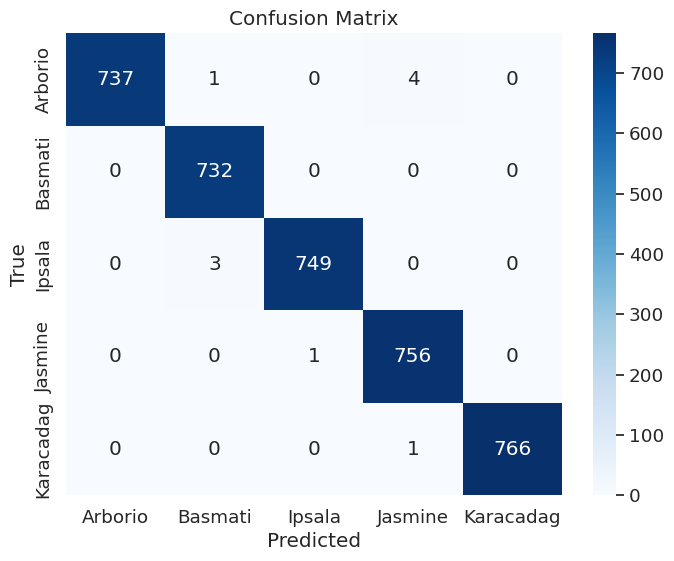

In [23]:
# Step 4: Evaluation

# Assuming you have 'num_classes' defined as the number of classes
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Load the saved model
model_inception.load_weights('inception_model.h5')  # Load the best weights obtained during training

# Make predictions on the test set
predictions = model_inception.predict(X_test_processed)

# Evaluate the model on the test set
inception_test_loss, inception_test_accuracy = model_inception.evaluate(X_test_processed, y_test_categorical, verbose=1)

# Print the test accuracy
print("Test Accuracy: {:.2f}%".format(inception_test_accuracy * 100))

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class labels
true_classes = np.argmax(y_test_categorical, axis=1)

# Generate classification report
class_labels = list(label_to_index.keys())
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

class_labels = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale as needed

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
# Set axis labels and plot title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()


train_acc.append(history_3.history['accuracy'][-1])
val_acc.append(history_3.history['val_accuracy'][-1])
test_acc.append(accuracy_score(true_classes, predicted_classes))

train_loss.append(history_3.history['loss'][-1])
val_loss.append(history_3.history['val_loss'][-1])
test_loss.append(log_loss(y_test_categorical, predictions))

**Xception Model**

In [24]:
from tensorflow.keras.applications import Xception

# Load the pre-trained Xception model (without top classification layers)
input_shape = (75, 75, 3)  # Adjust as needed
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model_xception = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_xception.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
model_checkpoint = ModelCheckpoint('xception_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train the model
history_4 = model_xception.fit(
    X_train_processed, y_train_categorical,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_processed, y_val_categorical),
    callbacks=[model_checkpoint, early_stopping]
)

# Save the model
model_xception.save('final_xception_model.h5')

83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/20
547/547 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9566
Epoch 1: val_loss improved from inf to 0.21258, saving model to xception_model.h5
547/547 [==============================] - 79s 88ms/step - loss: 0.1545 - accuracy: 0.9566 - val_loss: 0.2126 - val_accuracy: 0.9344
Epoch 2/20
547/547 [==============================] - ETA: 0s - loss: 0.0604 - accuracy: 0.9893
Epoch 2: val_loss improved from 0.21258 to 0.00941, saving model to xception_model.h5
547/547 [==============================] - 44s 81ms/step - loss: 0.0604 - accuracy: 0.9893 - val_loss: 0.0094 - val_accuracy: 0.9979
Epoch 3/20
547/547 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9858
Epoch 3: val_loss did not improve from 0.00941
547/547 [==============================] - 44s 81ms/step - loss: 0.0617 - accuracy: 0.9858 - val_loss: 0.0707 - val_accuracy: 0.9835
Epoch 4/20
547/547 [=============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



547/547 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9965
Epoch 8: val_loss did not improve from 0.00282
547/547 [==============================] - 44s 81ms/step - loss: 0.0162 - accuracy: 0.9965 - val_loss: 0.7752 - val_accuracy: 0.9083
Epoch 9/20
547/547 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9949
Epoch 9: val_loss did not improve from 0.00282
547/547 [==============================] - 44s 81ms/step - loss: 0.0197 - accuracy: 0.9949 - val_loss: 0.0061 - val_accuracy: 0.9989
Epoch 10/20
547/547 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.9985
Epoch 10: val_loss did not improve from 0.00282
547/547 [==============================] - 44s 81ms/step - loss: 0.0083 - accuracy: 0.9985 - val_loss: 0.0133 - val_accuracy: 0.9981
Epoch 11/20
547/547 [==============================] - ETA: 0s - loss: 0.0261 - accuracy: 0.9951
Epoch 11: val_loss did not improve from 0.00282
547/547 [===========================

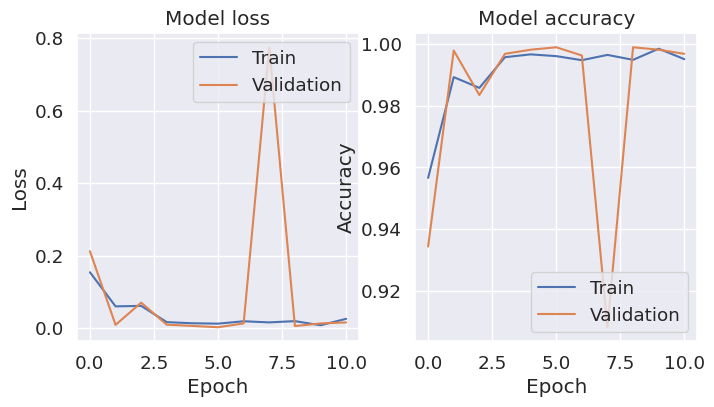

In [25]:
# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(122)
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

118/118 [==============================] - 2s 20ms/step - loss: 0.0020 - accuracy: 0.9995
Test Accuracy: 99.95%
Classification Report:
              precision    recall  f1-score   support

   Karacadag       1.00      1.00      1.00       742
     Basmati       1.00      1.00      1.00       732
     Jasmine       1.00      1.00      1.00       752
     Arborio       1.00      1.00      1.00       757
      Ipsala       1.00      1.00      1.00       767

    accuracy                           1.00      3750
   macro avg       1.00      1.00      1.00      3750
weighted avg       1.00      1.00      1.00      3750

Confusion Matrix:
[[741   0   0   1   0]
 [  0 732   0   0   0]
 [  0   0 751   1   0]
 [  0   0   0 757   0]
 [  0   0   0   0 767]]


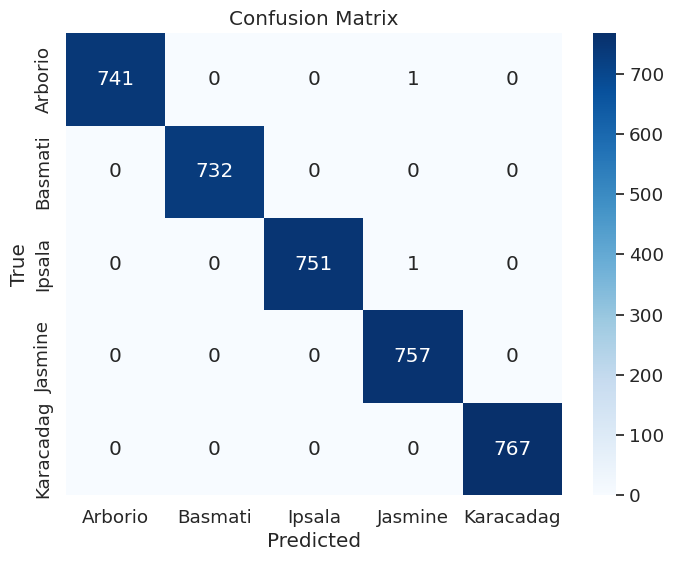

In [26]:
# Step 4: Evaluation

# Assuming you have 'num_classes' defined as the number of classes
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Load the saved model
model_xception.load_weights('xception_model.h5')  # Load the best weights obtained during training

# Make predictions on the test set
predictions = model_xception.predict(X_test_processed)

# Evaluate the model on the test set
xception_test_loss, xception_test_accuracy = model_xception.evaluate(X_test_processed, y_test_categorical, verbose=1)

# Print the test accuracy
print("Test Accuracy: {:.2f}%".format(xception_test_accuracy * 100))

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class labels
true_classes = np.argmax(y_test_categorical, axis=1)

# Generate classification report
class_labels = list(label_to_index.keys())
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

class_labels = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale as needed

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
# Set axis labels and plot title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

train_acc.append(history_4.history['accuracy'][-1])
val_acc.append(history_4.history['val_accuracy'][-1])
test_acc.append(accuracy_score(true_classes, predicted_classes))

train_loss.append(history_4.history['loss'][-1])
val_loss.append(history_4.history['val_loss'][-1])
test_loss.append(log_loss(y_test_categorical, predictions))

**Mobilenet Model**

In [27]:
from tensorflow.keras.applications import MobileNet

# Load the pre-trained MobileNet model (without top classification layers)
input_shape = (75, 75, 3)  # Adjust as needed
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_mobilenet.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
model_checkpoint = ModelCheckpoint('mobilenet_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train the model
history_5 = model_mobilenet.fit(
    X_train_processed, y_train_categorical,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_processed, y_val_categorical),
    callbacks=[model_checkpoint, early_stopping]
)

# Save the model
model_mobilenet.save('final_mobilenet_model.h5')

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/20
547/547 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9602
Epoch 1: val_loss improved from inf to 0.16482, saving model to mobilenet_model.h5
547/547 [==============================] - 32s 28ms/step - loss: 0.1840 - accuracy: 0.9602 - val_loss: 0.1648 - val_accuracy: 0.9739
Epoch 2/20
546/547 [============================>.] - ETA: 0s - loss: 0.0855 - accuracy: 0.9808
Epoch 2: val_loss improved from 0.16482 to 0.03248, saving model to mobilenet_model.h5
547/547 [==============================] - 14s 25ms/step - loss: 0.0855 - accuracy: 0.9808 - val_loss: 0.0325 - val_accuracy: 0.9912
Epoch 3/20
546/547 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9906
Epoch 3: val_loss did not improve from 0.03248
547/547 [==============================] - 14s 25ms/step - loss: 0.0435 - accuracy: 0.9905 - val_loss: 0.0571 - val_accuracy: 0.9816
Epoch 4/20
546/547 [===========

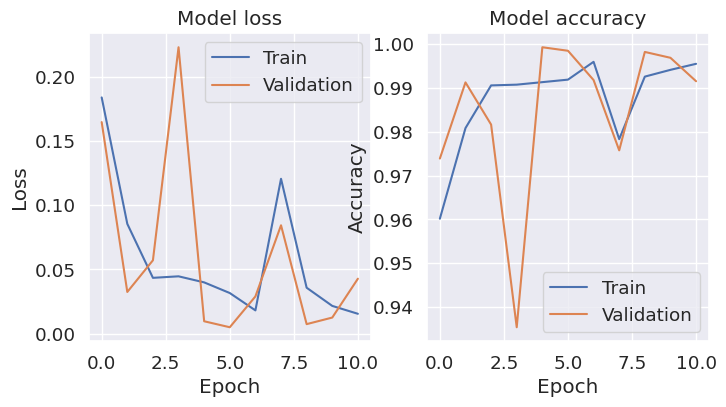

In [28]:
# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(122)
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

118/118 [==============================] - 1s 7ms/step - loss: 0.0016 - accuracy: 0.9997
Test Accuracy: 99.97%
Classification Report:
              precision    recall  f1-score   support

   Karacadag       1.00      1.00      1.00       742
     Basmati       1.00      1.00      1.00       732
     Jasmine       1.00      1.00      1.00       752
     Arborio       1.00      1.00      1.00       757
      Ipsala       1.00      1.00      1.00       767

    accuracy                           1.00      3750
   macro avg       1.00      1.00      1.00      3750
weighted avg       1.00      1.00      1.00      3750

Confusion Matrix:
[[742   0   0   0   0]
 [  0 731   1   0   0]
 [  0   0 752   0   0]
 [  0   0   0 757   0]
 [  0   0   0   0 767]]


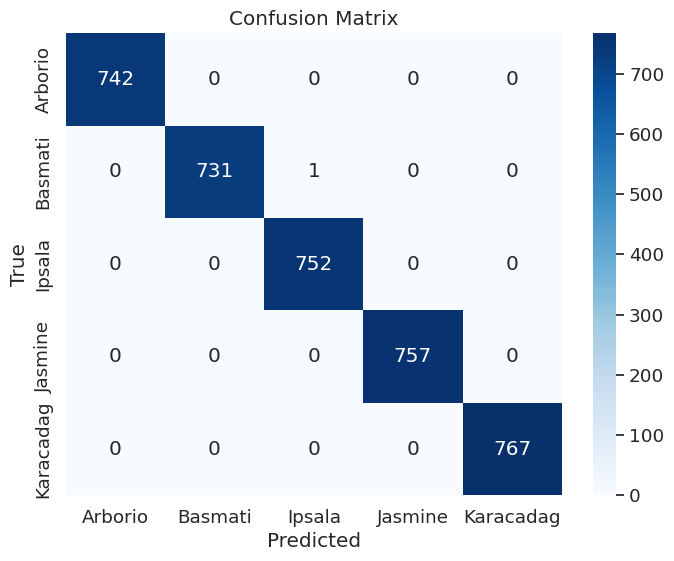

In [29]:
# Step 4: Evaluation

# Assuming you have 'num_classes' defined as the number of classes
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Load the saved model
model_mobilenet.load_weights('mobilenet_model.h5')  # Load the best weights obtained during training

# Make predictions on the test set
predictions = model_mobilenet.predict(X_test_processed)

# Evaluate the model on the test set
mobilenet_test_loss, mobilenet_test_accuracy = model_mobilenet.evaluate(X_test_processed, y_test_categorical, verbose=1)

# Print the test accuracy
print("Test Accuracy: {:.2f}%".format(mobilenet_test_accuracy * 100))

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class labels
true_classes = np.argmax(y_test_categorical, axis=1)

# Generate classification report
class_labels = list(label_to_index.keys())
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

class_labels = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale as needed

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
# Set axis labels and plot title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

train_acc.append(history_5.history['accuracy'][-1])
val_acc.append(history_5.history['val_accuracy'][-1])
test_acc.append(accuracy_score(true_classes, predicted_classes))

train_loss.append(history_5.history['loss'][-1])
val_loss.append(history_5.history['val_loss'][-1])
test_loss.append(log_loss(y_test_categorical, predictions))

**VGG-19 Model**

In [30]:
from tensorflow.keras.applications import VGG19

# Load the pre-trained VGG-19 model (without top classification layers)
input_shape = (75, 75, 3)  # Adjust as needed
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model_vgg19 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_vgg19.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
model_checkpoint = ModelCheckpoint('vgg_19_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train the model
history_6 = model_vgg19.fit(
    X_train_processed, y_train_categorical,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_processed, y_val_categorical),
    callbacks=[model_checkpoint, early_stopping]
)

# Save the model
model_mobilenet.save('final_vgg_19_model.h5')

80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/20
547/547 [==============================] - ETA: 0s - loss: 1.6222 - accuracy: 0.1954
Epoch 1: val_loss improved from inf to 1.60944, saving model to vgg_19_model.h5
547/547 [==============================] - 53s 86ms/step - loss: 1.6222 - accuracy: 0.1954 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 2/20
547/547 [==============================] - ETA: 0s - loss: 1.6098 - accuracy: 0.1966
Epoch 2: val_loss did not improve from 1.60944
547/547 [==============================] - 46s 84ms/step - loss: 1.6098 - accuracy: 0.1966 - val_loss: 1.6096 - val_accuracy: 0.2013
Epoch 3/20
547/547 [==============================] - ETA: 0s - loss: 1.6098 - accuracy: 0.2013
Epoch 3: val_loss did not improve from 1.60944
547/547 [==============================] - 46s 84ms/step - loss: 1.6098 - accuracy: 0.2013 - val_loss: 1.6097 - val_accuracy: 0.2000
Epoch 4/20
547/547 [==============================] - ETA: 0s - loss: 1.60

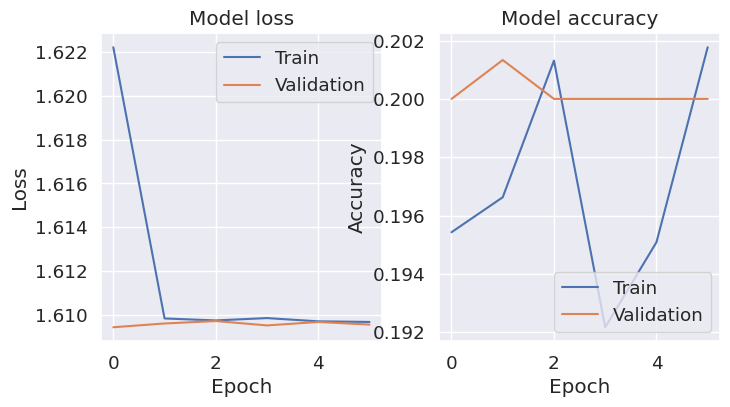

In [31]:
# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(122)
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

118/118 [==============================] - 3s 25ms/step - loss: 1.6098 - accuracy: 0.1952
Test Accuracy: 19.52%
Classification Report:
              precision    recall  f1-score   support

   Karacadag       0.00      0.00      0.00       742
     Basmati       0.20      1.00      0.33       732
     Jasmine       0.00      0.00      0.00       752
     Arborio       0.00      0.00      0.00       757
      Ipsala       0.00      0.00      0.00       767

    accuracy                           0.20      3750
   macro avg       0.04      0.20      0.07      3750
weighted avg       0.04      0.20      0.06      3750

Confusion Matrix:
[[  0 742   0   0   0]
 [  0 732   0   0   0]
 [  0 752   0   0   0]
 [  0 757   0   0   0]
 [  0 767   0   0   0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


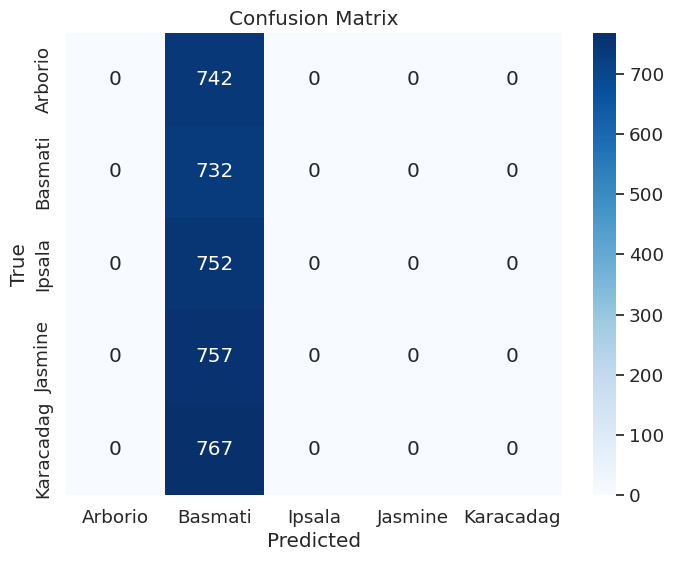

In [32]:
# Step 4: Evaluation

# Assuming you have 'num_classes' defined as the number of classes
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Load the saved model
model_vgg19.load_weights('vgg_19_model.h5')  # Load the best weights obtained during training

# Make predictions on the test set
predictions = model_vgg19.predict(X_test_processed)

# Evaluate the model on the test set
vgg19_test_loss, vgg19_test_accuracy = model_vgg19.evaluate(X_test_processed, y_test_categorical, verbose=1)

# Print the test accuracy
print("Test Accuracy: {:.2f}%".format(vgg19_test_accuracy * 100))

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class labels
true_classes = np.argmax(y_test_categorical, axis=1)

# Generate classification report
class_labels = list(label_to_index.keys())
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

class_labels = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale as needed

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
# Set axis labels and plot title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

train_acc.append(history_6.history['accuracy'][-1])
val_acc.append(history_6.history['val_accuracy'][-1])
test_acc.append(accuracy_score(true_classes, predicted_classes))

train_loss.append(history_6.history['loss'][-1])
val_loss.append(history_6.history['val_loss'][-1])
test_loss.append(log_loss(y_test_categorical, predictions))

In [34]:
results = {"Models": models, "Train Accuracy": train_acc, "Val_Accuracy": val_acc, "Test Accuracy": test_acc, "Train Loss": train_loss,
          "Test loss": test_loss, "Validation Loss": val_loss}

# Create a dataframe
import pandas as pd
df = pd.DataFrame(results)

# Display the dataframe
print(df)

      Models  Train Accuracy  Val_Accuracy  Test Accuracy  Train Loss  \
0     VGG-16        0.981600      0.985600       0.918400    0.059959   
1     ResNet        0.990457      0.983467       0.991733    0.034593   
2   DenseNet        0.986114      0.945867       0.992267    0.046054   
3  Inception        0.993371      0.988533       0.997333    0.027918   
4   Xception        0.995086      0.996800       0.999467    0.026094   
5  MobileNet        0.995429      0.991467       0.999733    0.015482   
6      VGG19        0.201771      0.200000       0.195200    1.609686   

   Test loss  Validation Loss  
0   0.228547         0.052533  
1   0.026396         0.057247  
2   0.031630         0.187432  
3   0.008099         0.044585  
4   0.001957         0.016109  
5   0.001561         0.042809  
6   1.609780         1.609565  
